In [21]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import sys 
from os import path as pt
import numpy as np
import matplotlib.pyplot as plt
import ot
from tqdm import tqdm
import random

np.random.seed(0)
random.seed(0)
verbose = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


# Old implementation

mu
Cholesky:
[[1 0 0]
 [1 2 0]
 [1 2 1]]
Covariance:
[[1 1 1]
 [1 5 5]
 [1 5 6]]
nu
Cholesky:
[[1 0 0]
 [2 1 0]
 [2 1 2]]
Covariance:
[[1 2 2]
 [2 5 5]
 [2 5 9]]


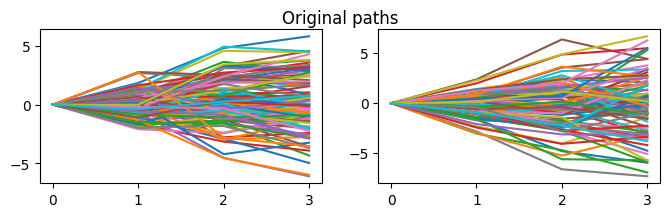

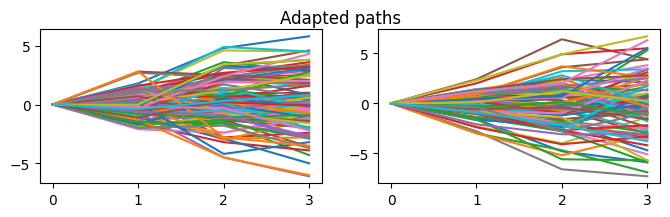

In [26]:
# Markovian
# Initialize samples
from utils import Lmatrix2paths, adapted_empirical_measure


T = 3 # we always start the path with 0, here T is the non-trivial timestep, so for T = 2, the path looks like (0,x,y)
n_sample = 20000
normalize = False


print("mu")
L = np.array([[1, 0, 0], [1, 2, 0], [1, 2, 1]])
X,A = Lmatrix2paths(L, n_sample)

print("nu")
M = np.array([[1, 0, 0], [2, 1, 0], [2, 1, 2]])
Y,B = Lmatrix2paths(M, n_sample)

if verbose:
    fig, ax = plt.subplots(1, 2, figsize=[8, 2])
    ax[0].plot(X[:,:100])
    ax[1].plot(Y[:,:100])
    plt.suptitle('Original paths')
    plt.show()

# Grid projection of k-mean projection
adaptedX = adapted_empirical_measure(X, delta_n = 0.1)
adaptedY = adapted_empirical_measure(Y, delta_n = 0.1)

if verbose:
    fig, ax = plt.subplots(1,2, figsize=[8, 2])
    ax[0].plot(adaptedX[:,:100])
    ax[1].plot(adaptedY[:,:100])
    plt.suptitle('Adapted paths')
    plt.show()

In [4]:
# Quantization 
# Here I use union of both X and Y samples grid for simplicity.
q2v = np.unique(np.concatenate([adaptedX,adaptedY],axis = 0))  # Quantization to Value
v2q = {k: v for v, k in enumerate(q2v)} # Value to Quantization
print('Number of distint values: ', len(q2v))

Number of distint values:  210


In [5]:
from collections import defaultdict

def path2cm(adaptedpath, v2q, markovian = False):
    r'''
    Path to Conditional Measure
    e.g. 
    mu_x[0] = {(3,): {1: 1, 2: 5}}
    ......
    '''
    T = len(adaptedpath)-1
    mu_x = [defaultdict(dict) for t in range(T)]
    for path in adaptedpath.T:
        for t in range(T):
            if markovian:
                pre_path = v2q[path[t]]
            else:
                pre_path = tuple(v2q[v] for v in path[:t+1])   # 
            next_val = v2q[path[t+1]]
            if pre_path not in mu_x[t] or next_val not in mu_x[t][pre_path]:
                mu_x[t][pre_path][next_val] = 1
            else:
                mu_x[t][pre_path][next_val] += 1
    return mu_x
mu_x = path2cm(adaptedX, v2q, markovian=True)
nu_y = path2cm(adaptedY, v2q, markovian=True)

print('Number of condition subpaths of mu_x')
for t in range(T):
    print(f'Time {t}: {len(mu_x[t])}')

print('Number of condition subpaths of nu_y')
for t in range(T):
    print(f'Time {t}: {len(nu_y[t])}')

Number of condition subpaths of mu_x
Time 0: 1
Time 1: 75
Time 2: 166
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 76
Time 2: 162


In [6]:
q2v_x = [list(mu_x[t].keys()) for t in range(T)]   # quantization to tuple value e.g. q2v_x[2][33] ---> (2,3,4)
v2q_x = [{k: v for v, k in enumerate(q2v_x[t])} for t in range(T)] # tuple value to quantization:  v2q_x[2](2,3,4) ---> 33

q2v_y = [list(nu_y[t].keys()) for t in range(T)]  # quantization to tuple value e.g. q2v_x[2][33] ---> (2,3,4)
v2q_y = [{k: v for v, k in enumerate(q2v_y[t])} for t in range(T)] # tuple value to quantization:  v2q_x[2](2,3,4) ---> 33

In [7]:
def nested_markovian(mu_x, nu_y, square_cost_matrix):
    T = len(mu_x)+1
    V = [np.zeros([len(q2v),len(q2v)]) for t in range(T)]  # We could use sparse matrix
    for t in tqdm(range(T-2,-1,-1)):
        for k1,v1 in mu_x[t].items():
            for k2,v2 in nu_y[t].items():
                w1 = list(v1.values())
                w1 = np.array(w1)/sum(w1)

                w2 = list(v2.values())
                w2 = np.array(w2)/sum(w2)

                q1s = list(v1.keys())
                q2s = list(v2.keys())

                cost = square_cost_matrix[np.ix_(q1s,q2s)] + V[t+1][np.ix_(q1s,q2s)]
                V[t][k1,k2] = ot.emd2(w1, w2, cost)

    AW_2square = V[0][k1,k2]
    return AW_2square

In [8]:
square_cost_matrix = (q2v[None,:] - q2v[None,:].T)**2
# AW_2square = nested_markovian(mu_x, nu_y, square_cost_matrix)
%lprun -f nested_markovian AW_2square = nested_markovian(mu_x, nu_y, square_cost_matrix)

100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


Timer unit: 1e-09 s

Total time: 7.33216 s
File: /var/folders/gq/bts52kyn0v72cpz5c5489984006lvv/T/ipykernel_29880/871942015.py
Function: nested_markovian at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def nested_markovian(mu_x, nu_y, square_cost_matrix):
     2         1          0.0      0.0      0.0      T = len(mu_x)+1
     3         1     134000.0 134000.0      0.0      V = [np.zeros([len(q2v),len(q2v)]) for t in range(T)]  # We could use sparse matrix
     4         4   12678000.0    3e+06      0.2      for t in tqdm(range(T-2,-1,-1)):
     5       245     120000.0    489.8      0.0          for k1,v1 in mu_x[t].items():
     6     32835    6261000.0    190.7      0.1              for k2,v2 in nu_y[t].items():
     7     32593   16581000.0    508.7      0.2                  w1 = list(v1.values())
     8     32593   81451000.0   2499.0      1.1                  w1 = np.array(w1)/sum(w1)
     9              

In [9]:
def adapted_wasserstein_squared(a, A, b, B):
    # Cholesky decompositions: A = L L^T, B = M M^T
    L = np.linalg.cholesky(A)
    M = np.linalg.cholesky(B)
    # Mean squared difference
    mean_diff = np.sum((a - b) ** 2)
    # Trace terms
    trace_sum = np.trace(A) + np.trace(B)
    # L1 norm of diagonal elements of L^T M
    l1_diag = np.sum(np.abs(np.diag(L.T @ M)))
    # Final adapted Wasserstein squared distance
    return mean_diff + trace_sum - 2 * l1_diag

a, b  = np.zeros([3]), np.zeros([3])
dist_bench = adapted_wasserstein_squared(a,A,b,B)
print('Theoretical AW_2^2: ', dist_bench)
print('Numerical AW_2^2: ', AW_2square)

Theoretical AW_2^2:  5.0
Numerical AW_2^2:  4.985159159665507


# New implementation

In [11]:
# Quantization
from collections import defaultdict

def quantization(adaptedX, adaptedY, markovian = False):
    T = len(adaptedX)-1

    # Global quantization for X union Y samples on grid for
    q2v = np.unique(
        np.concatenate([adaptedX, adaptedY], axis=0)
    )  # Quantization to Value
    v2q = {k: v for v, k in enumerate(q2v)}  # Value to Quantization
    print("Number of distint values: ", len(q2v))
    
    def adapted_path2conditional_measure(adaptedpath, v2q, markovian):
        r"""
        Path to Conditional Measure
        non-Markovian:
        mu_x[0] = {(3,): {1: 1, 2: 5}}
        Markovian:
        mu_x[0] = {3: {1: 1, 2: 5}}
        """
        mu_x = [defaultdict(dict) for t in range(T)]
        for path in adaptedpath.T:
            for t in range(T):
                if markovian:
                    pre_path = v2q[path[t]]
                else:
                    pre_path = tuple(v2q[v] for v in path[: t + 1])  #
                next_val = v2q[path[t + 1]]
                if pre_path not in mu_x[t] or next_val not in mu_x[t][pre_path]:
                    mu_x[t][pre_path][next_val] = 1
                else:
                    mu_x[t][pre_path][next_val] += 1
        return mu_x
    
    mu_x = adapted_path2conditional_measure(adaptedX, v2q, markovian=markovian)
    nu_y = adapted_path2conditional_measure(adaptedY, v2q, markovian=markovian)
    
    print('Number of condition subpaths of mu_x')
    for t in range(T):
        print(f'Time {t}: {len(mu_x[t])}')

    print('Number of condition subpaths of nu_y')
    for t in range(T):
        print(f'Time {t}: {len(nu_y[t])}')

    # Conditional Measure to Time Quantization
    # Quantization of history sub-paths
    # non-Markovian: quantization of tuple value e.g. q2v_x[2][33] ---> (2,3,4);
    # Markovian: quantization of integer value e.g. q2v_x[2][33] ---> (4);

    q2v_x = [list(mu_x[t].keys()) for t in range(T)]    
    v2q_x = [{k: v for v, k in enumerate(q2v_x[t])} for t in range(T)] 

    q2v_y = [list(nu_y[t].keys()) for t in range(T)]
    v2q_y = [{k: v for v, k in enumerate(q2v_y[t])} for t in range(T)]

    return q2v, v2q, mu_x, nu_y, q2v_x, v2q_x, q2v_y, v2q_y
    
q2v, v2q, mu_x, nu_y, q2v_x, v2q_x, q2v_y, v2q_y = quantization(adaptedX, adaptedY, markovian = True)

Number of distint values:  210
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 75
Time 2: 166
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 76
Time 2: 162


In [12]:
def nested(mu_x, nu_y, square_cost_matrix, markovian = False):
    T = len(mu_x)
    V = [np.zeros([len(v2q_x[t]),len(v2q_y[t])]) for t in range(T)]
    for t in tqdm(range(T-1,-1,-1)):
        print(t)
        for k1,v1 in mu_x[t].items():
            for k2,v2 in nu_y[t].items():
                # list of probability of conditional distribution mu_x
                w1 = list(v1.values()) 
                w1 = np.array(w1)/sum(w1) 
                # list of probability of conditional distribution nu_y
                w2 = list(v2.values())
                w2 = np.array(w2)/sum(w2)
                # list of quantized values of conditional distribution mu_x (nu_y)
                q1 = list(v1.keys())
                q2 = list(v2.keys())
                # square cost of the values indexed by quantized values: |q2v[q1] - q2v[q2]|^2
                cost = square_cost_matrix[np.ix_(q1,q2)]

                # At T-1: add V[T] = 0, otherwise add the V[t+1] already computed 
                if t < T-1:
                    if markovian: # If markovian, for condition path (k1,q), only the last value q matters, and V[t+1] is indexed by the time re-quantization of q
                        q1s = [v2q_x[t+1][q] for q in v1.keys()]  
                        q2s = [v2q_y[t+1][q] for q in v2.keys()]
                    else: # If non-markovian, for condition path (k1,q), the V[t+1] is indexed by the time re-quantization of tuple (k1,q)
                        q1s = [v2q_x[t+1][k1+(q,)] for q in v1.keys()]
                        q2s = [v2q_y[t+1][k2+(q,)] for q in v2.keys()]
                    cost += V[t+1][np.ix_(q1s,q2s)]
                try:
                    V[t][v2q_x[t][k1],v2q_y[t][k2]] = ot.emd2(w1, w2, cost) # solve the OT problem with cost |x_t-y_t|^2 + V_{t+1}(x_{1:t},y_{1:t})
                except:
                    print(k1,k2)
                    print(v2q_x[t][k1],v2q_y[t][k2])
                    print(V[t].shape)
                    V[1.2]

    AW_2square = V[0][0,0]
    return AW_2square

nested(mu_x, nu_y, square_cost_matrix, markovian=True)

  0%|          | 0/3 [00:00<?, ?it/s]

2


 33%|███▎      | 1/3 [00:04<00:09,  4.64s/it]

1


100%|██████████| 3/3 [00:06<00:00,  2.03s/it]

0


np.float64(4.985159159665507)